In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs, plot_grid_anchors
from src.postprocessing import bbox_iou, decode_model_outputs, non_max_suppression, NMS
from src.callbacks import create_callbacks
from models.bbox_preprocess import TransformBoxes
from models.loss import lossFunction
from models.model import Mean, MyModel, make_dummy_model
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys

In [3]:
class args:
    img_size = (256, 256)
    buffer_size = 64
    batch_size = 16
    epochs = 100
    NUM_CLASSES = 100
    aug_translate = 0.2
    aug_rot = 40
    aug_scale = 0.35
    aug_kernel_size = 5
    aug_sigma = 1
    ada_initial_probability = 0.0
    lambda_box = 5
    lambda_noobj = 10 # 0.5
    lambda_class = 1
    max_output_size = 50
    max_output_size_per_class = 30
    iou_threshold = 0.5
    confidence_threshold = 0.5
    ignore_thresh = 0.5
    optimizer = 'adam'
    monitor = 'loss'

config_opt = {"learning_rate": 1e-3, "beta_1": 0.15, "beta_2": 0.99, "epsilon": 1e-8}
grid_sizes = [8, 16, 32] # [8, 16, 32], [13, 26, 52]
num_scales = len(grid_sizes)
norm_anchors = tf.constant([
                            [(116, 90), (156, 198), (373, 326)],
                            [(30, 61),   (62, 45),   (59, 119)], 
                            [(10, 13),   (16, 30),    (33, 23)]
                            ], tf.float32) / 416.
num_anchors_per_scale = tf.math.count_nonzero(norm_anchors, axis=[0, -1]) / 2
assert len(grid_sizes) == norm_anchors.shape[0]


voc_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_train.tfrecord"
voc_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_val.tfrecord"
coco_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord"
coco_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord"
img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png'
save_model_path = r'D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5'

augmentations = [RandomHorizontalFlip(), 
                 RandomTranslate(translate=args.aug_translate), 
                 RandomRotate(rot=args.aug_rot), 
                 RandomZoom(scale=args.aug_scale), 
                 RandomMirror(), 
                 AddNoise(), 
                 RandomGamma(), 
                 GaussianBlur(kernel_size=args.aug_kernel_size, sigma=args.aug_sigma)]

# Load Data

In [4]:
ds_train = load_coco_dataset(args, coco_val_ds_path, augment_func = None, split = 'train') ######################### USE VAL FOR NOW AS TRAIN IS LONG
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord...


In [5]:
tmvm = iter(ds_train)

In [6]:
kvsdk = next(tmvm)

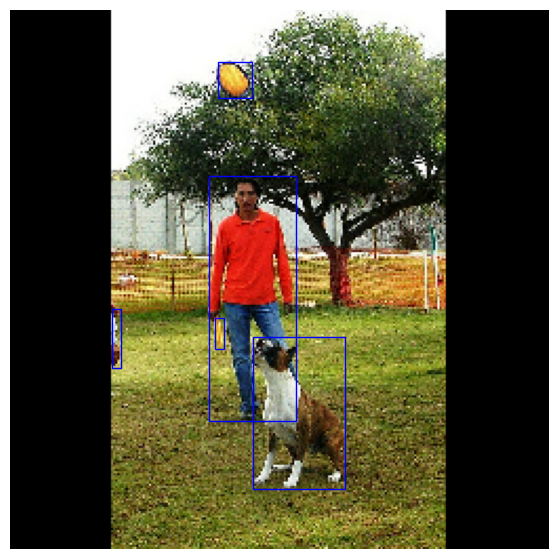

In [7]:
i = 0
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [8]:
setup_bboxes = TransformBoxes(args, grid_sizes, norm_anchors)

In [9]:
grid = setup_bboxes(kvsdk[1])

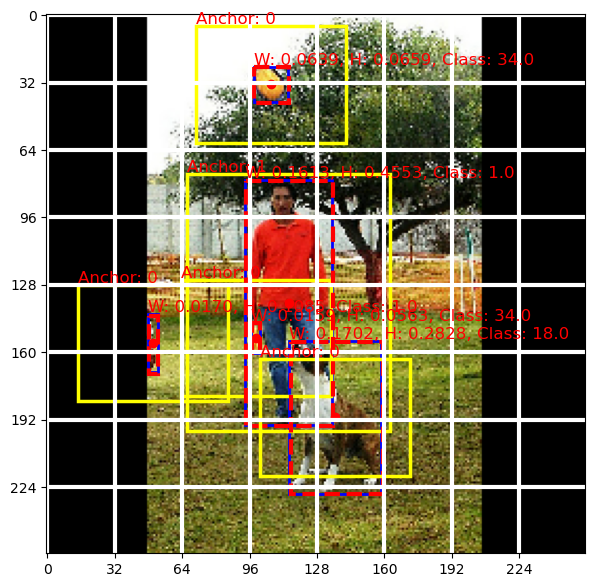

Total bboxes: 5, Total anchors: 5


In [10]:
c = 0
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (7, 7), norm_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Make Sure Augmentations Work

In [13]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [14]:
augmenter.update(tf.constant(0.5))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.2496521]], dtype=float32)>


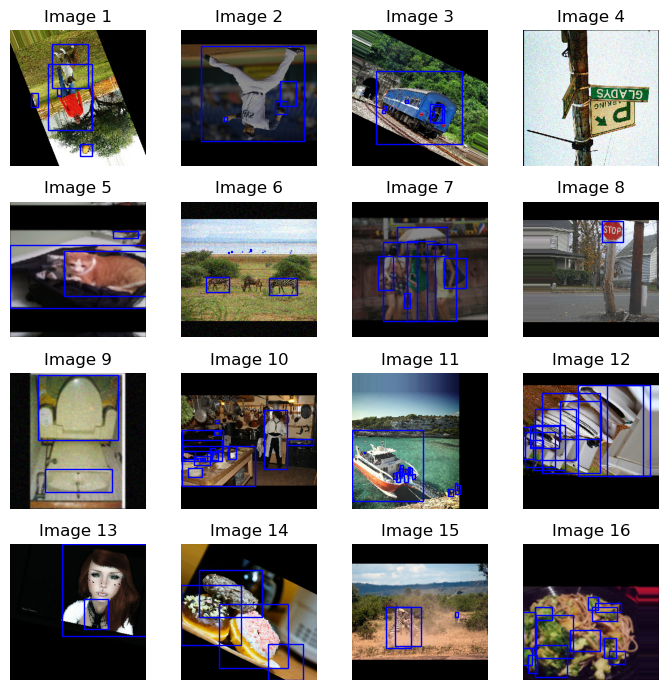

In [15]:
visualize_outputs(test_ada[0], test_ada[1][..., :-1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [16]:
grid2 = setup_bboxes(test_ada[1])

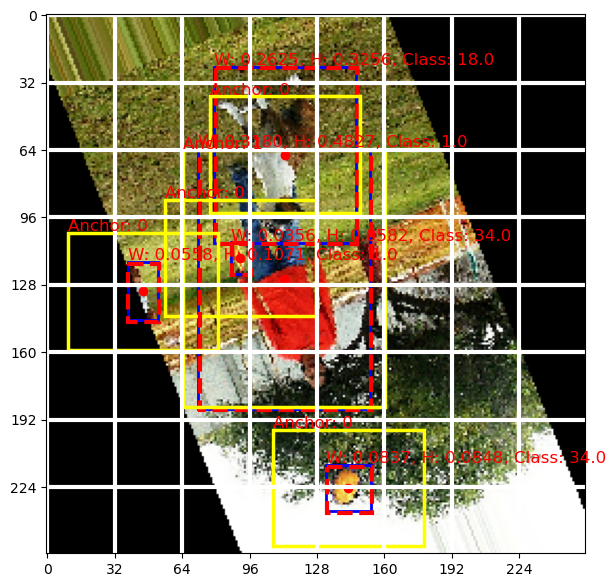

Total bboxes: 5, Total anchors: 5


In [19]:
c = 0
indx = 0
plot_grid_anchors(test_ada[0][indx], test_ada[1][indx], grid2[c][indx], (7, 7), norm_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Train

In [11]:
class MyModel(tf.keras.Model):

    def __init__(self, 
                 img_size,
                 augment_func,
                 grid_sizes,
                 anchors,
                 args,
                 **kwargs):
               
        super(MyModel, self).__init__(**kwargs)

        self.img_size = img_size
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.model = make_dummy_model(img_size, grid_sizes, classes = args.NUM_CLASSES, num_anchors = 3)
        self.transformBoxes = TransformBoxes(args=args, grid_sizes=grid_sizes, anchors=anchors)
        self.args = args
        self.anchors = anchors
        self.ada = augment_func

    def compile(self, optimizer=None, metrics=[], *args, **kwargs):

        assert isinstance(metrics, list), "metrics must be a list"
        self.train_step_counter.assign(0)
        self.optimizer = optimizer
        self.augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
        self.iou_tracker = tf.keras.metrics.Mean(name="iou_tracker")
        super(MyModel, self).compile(metrics=metrics, *args, **kwargs)

    def post_process(self, predicted, anchors):
        
        # Get bboxes predicted out: [BS, gy, gx, NUM_ANCHORS, (y, x, h, w)], [BS, gy, gx, NUM_ANCHORS, 1], [BS, gy, gx, NUM_ANCHORS, NUM_CLASSES]
        pred_bbox, pred_confidence, pred_obj_class, _ = decode_model_outputs(predicted, anchors)

        # NMS out: [BS, max_output_size, (y, x, y, x)], [BS, max_output_size], [BS, max_output_size]
        boxes, scores, classes, _ = non_max_suppression(pred_bbox, pred_confidence, pred_obj_class, self.args.NUM_CLASSES, self.args.max_output_size, self.args.max_output_size_per_class, self.args.iou_threshold, self.args.confidence_threshold)
        return boxes, scores, classes

    def get_iou(self, true_bboxes, true_mask, predicted, anchors):

        boxes, _, _ = self.post_process(predicted, anchors)
        iou = bbox_iou(true_bboxes, boxes) * true_mask # IOU out: [BS, N, max_output_size]
        return tf.reduce_mean(iou, axis=(2, 1, 0))

    def train_step(self, ds_input): # image (BS, H, W, C), bboxes (BS, N, 5)

        self.train_step_counter.assign_add(1)

        # Augment images and get mask
        augmented_images, augmented_bboxes = self.ada(ds_input, training=True) # augmented_images - [BS, H, W, C], augmented_bboxes - [BS, N, (y1, x1, y2, x2, obj_class)]
        true_mask = tf.math.count_nonzero(augmented_bboxes, axis=-1,  dtype=tf.bool)[..., None]
        true_mask = tf.cast(true_mask, tf.float32) # (BS, N, 1)

        # Trasform bboxes to grid inputs
        grid_aug_bboxes = self.transformBoxes(augmented_bboxes) # out: [BS, gy, gx, num_anchors, (y, x, h, w, p, obj_class)] x 3
        
        # Gradient
        with tf.GradientTape() as tape:
            
            # Get predicted and loss
            predicted = self.model(augmented_images, training=True) # out: [BS, gy, gx, num_anchors, (y, x, h, w, p, NUM_CLASSES)] x 3
            loss = self.compiled_loss(grid_aug_bboxes, predicted)
        
        # Optimize
        trainable_weights = self.model.trainable_weights
        model_grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(model_grads, trainable_weights))

        # Get Resulting IOU
        iou1 = self.get_iou(augmented_bboxes[..., :-1], true_mask, predicted[0], self.anchors[0])
        iou2 = self.get_iou(augmented_bboxes[..., :-1], true_mask, predicted[1], self.anchors[1])
        iou3 = self.get_iou(augmented_bboxes[..., :-1], true_mask, predicted[2], self.anchors[2])
        total_iou = (iou1 + iou2 + iou3) / 3.

        # Update metrics
        self.ada.update(1. - total_iou) # Why 1 - iou? Because inside Ada: accuracy = K.mean(1. - loss)
        self.compiled_metrics.update_state([loss], [loss])
        self.augmentation_probability_tracker.update_state(self.ada.probability)
        self.iou_tracker.update_state(total_iou)
        
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, augment=False):

        augmented_images, augmented_masks = self.ada(inputs, training=training) if augment else inputs
        predicted = self.model(augmented_images, training=training)
        return augmented_images, augmented_masks, predicted

In [12]:
def setupModel(args, grid_sizes, anchors, augmentations, save_model_path, config_opt):

    augment_func = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=args.ada_initial_probability, switch=True)
    test_mymodel = MyModel(img_size=args.img_size, augment_func=augment_func, grid_sizes=grid_sizes, anchors=anchors, args=args)

    loss_list = []
    for i in range(anchors.shape[0]):
        loss = lossFunction(anchors[i], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
        loss_list.append(loss)
    callback_list = create_callbacks(save_model_path, args, test_mymodel, anchors, img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png')

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]
        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
        optimizer = optimizer.from_config(config=config_opt)

    else:
        optimizer = tf.keras.optimizers.get(args.optimizer)
        optimizer = optimizer.from_config(config=config_opt)

    return test_mymodel, loss_list, callback_list, optimizer

In [13]:
test_mymodel, loss_list, callbacks_list, optimizer = setupModel(args, grid_sizes, norm_anchors, augmentations, save_model_path, config_opt)

In [14]:
test_mymodel.compile(optimizer=optimizer, metrics = [Mean(name="aug_probability")], loss=loss_list)

Epoch 1/4


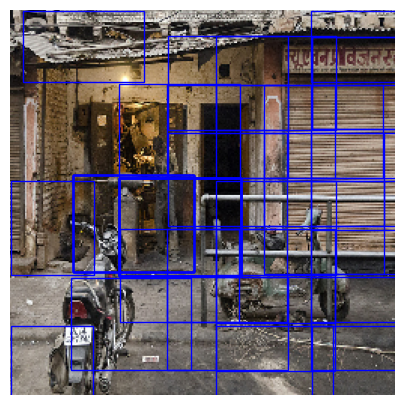

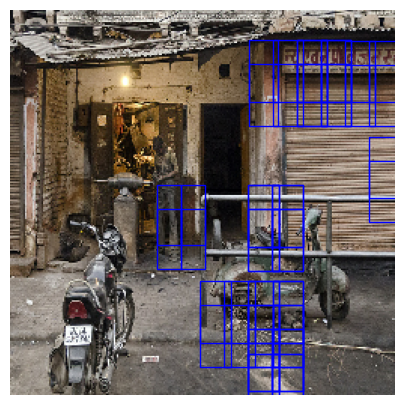

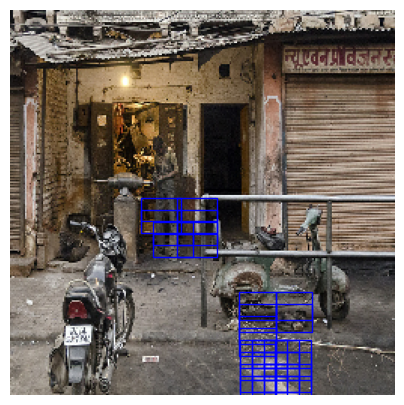

312/312 [==============================] - 73s 229ms/step - loss: 115.7999 - output_1_loss: 35.2401 - output_2_loss: 41.7453 - output_3_loss: 38.8145 - aug_probability: 0.0301 - iou_tracker: 0.1044

Epoch 1: loss improved from 118.83013916015625 to 115.79994201660156, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 2/4
312/312 [==============================] - 72s 231ms/step - loss: 113.9772 - output_1_loss: 34.6684 - output_2_loss: 41.3044 - output_3_loss: 38.0043 - aug_probability: 0.0313 - iou_tracker: 0.1081

Epoch 2: loss improved from 115.79994201660156 to 113.97724151611328, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 3/4


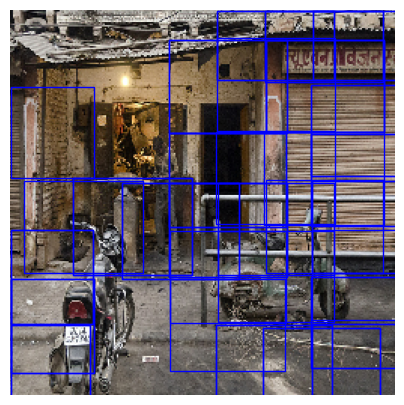

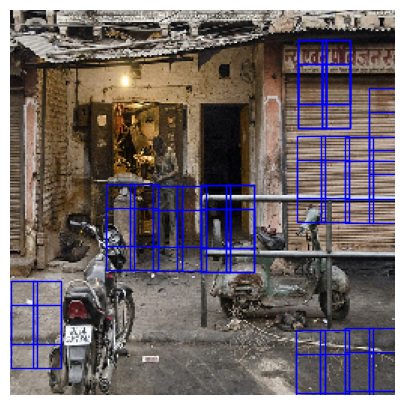

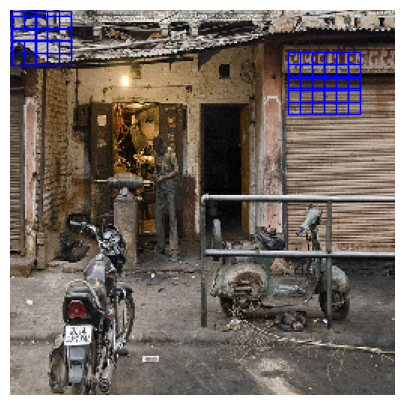

312/312 [==============================] - 76s 239ms/step - loss: 112.7962 - output_1_loss: 34.1647 - output_2_loss: 41.1292 - output_3_loss: 37.5023 - aug_probability: 0.0318 - iou_tracker: 0.1094

Epoch 3: loss improved from 113.97724151611328 to 112.79618835449219, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 4/4
312/312 [==============================] - 71s 227ms/step - loss: 112.0775 - output_1_loss: 33.8256 - output_2_loss: 41.0296 - output_3_loss: 37.2223 - aug_probability: 0.0332 - iou_tracker: 0.1136

Epoch 4: loss improved from 112.79618835449219 to 112.07747650146484, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5


In [16]:
test_mymodel.fit(ds_train, epochs=4, callbacks=callbacks_list)

In [ ]:
        # bs = tf.shape(bboxes)[0]
        # bboxes_input = tf.repeat(bboxes[None, ...], repeats=self.num_scales, axis=0)
        # fn_output_signature = tf.RaggedTensorSpec(shape=(self.args.batch_size, None,  None, self.num_anchors, 6), ragged_rank=2)
        # return tf.map_fn(lambda x: self.bboxes_to_grid(x[0], x[1], x[2], x[3]), elems=(bboxes_input, self.grid_sizes, self.anchors, self.num_anchors_per_scale), fn_output_signature=fn_output_signature)

In [ ]:
        # loss2 = lossFunction(anchors[1], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
        # loss3 = lossFunction(anchors[2], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
    # loss_list = [loss1, loss2, loss3]


In [ ]:
        # # Post processing
        # boxes1, _, _ = self.post_process(predicted[0], self.anchors[0])
        # boxes2, _, _ = self.post_process(predicted[1], self.anchors[1])
        # boxes3, _, _ = self.post_process(predicted[2], self.anchors[2])

        # # IOU out: [BS, N, max_output_size]
        # iou1 = bbox_iou(augmented_bboxes[..., :-1], boxes1) * true_mask
        # iou2 = bbox_iou(augmented_bboxes[..., :-1], boxes2) * true_mask
        # iou3 = bbox_iou(augmented_bboxes[..., :-1], boxes3) * true_mask

        # # Get mean IOU to update Ada
        # iou1 = tf.reduce_mean(iou1, axis=(2, 1, 0))
        # iou2 = tf.reduce_mean(iou2, axis=(2, 1, 0))
        # iou3 = tf.reduce_mean(iou3, axis=(2, 1, 0))
        # total_iou = (iou1 + iou2 + iou3) / 3.